# The Impact of Channel Bonding on 802.11n Network Management

## 5 Ghz Band Experemantation Enviroment

**Disabling CCA**

We disable CCA (actually disable bss neighbor /force 40 MHz channels in hostapd) by changing the src/ap/hw_features.c file from the source code of hostapd to ignore the overlapping BSSes. We actually modify the case where 20/40 MHz operation is not permitted by comment out iface->conf->secondary_channel = 0; DILLIGAF . Then we compiled our new hostapd and run it as executable in the compiled directory: (./hostapd -dd hostapd.conf)

**Enabling 5Ghz Band**

The problem is evident when executing hostapd with the -dd flag , in which case it lists the allowed channels. And none of the 5 GHz channels is listed. The underlying reason is the “no IR” part given in “iw list”, meaning no Initial Radiation, hence no access point allowed. The card was set to a "world" regulatory domain in EEPROM, therefore all channels in the 5GHz band have "No-IR" flag set.

So we solve it by edit drivers/net/wireless/ath/regd.c and neutralize the following functions with a “return” immediately after variable declarations. Or replace them with functions just returning immediately:
ath_reg_apply_beaconing_flags()
ath_reg_apply_ir_flags()
ath_reg_apply_radar_flags()

Then we set the flag ATH_USER_REGD to 1.Then we had to recompile ath9k to get it to not restrict by EEPROM code. 
After the recompile we force the regulatory domain by running: sudo modprobe cfg80211 ieee80211_regdom=GR

**Measurement Environment**

- We generate constant bit-rate UDP traffic between the transmitter and receiver pairs using the iperf tool, with fixed packet sizes of 500 bytes. We monitor UDP flows and evaluate their performance in terms of MAC layer throughput.

- We disable the ath9k automatic rate selection scheme and control the transmission MCS using a set of custom scripts:

        while true; do cat /sys/kernel/debug/ieee80211/phy0/netdev:wlan0/stations/*/rc_stats; sleep 1; done; 

        echo 0 > /sys/kernel/debug/ieee80211/phy0/rc/fixed_rate_idx


- We also control the channel width to determine the performance differences between operating on a 20MHz channel and switching to a wider 40MHz channel. We run our experiments for all supported MCS values. As a result, we identify the best MCS for each tested link and channel width configuration.

- We identify two interference patterns from neighboring links : co-channel and adjacent channel interference.

## 20 Mhz Under Test

### 20 Mhz Link

**Best MCS: MCS23 , index: 27 (LGI 3)**

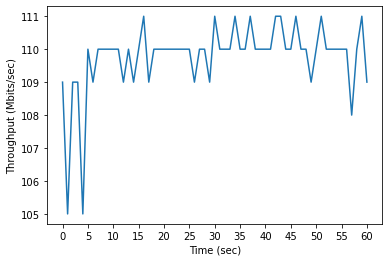

In [1]:
from matplotlib import pyplot as plt
x = [ 0.0 , 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 6.0 , 7.0 , 8.0 , 9.0 ,10.0 ,11.0 ,12.0 ,13.0 ,14.0 ,15.0 ,16.0 ,17.0 ,18.0 ,19.0 ,20.0 ,21.0 ,22.0 ,23.0 ,24.0 ,25.0 ,26.0 ,27.0 ,28.0 ,29.0 ,30.0 ,31.0 ,32.0 ,33.0 ,34.0 ,35.0 ,36.0 ,37.0 ,38.0 ,39.0 ,40.0 ,41.0 ,42.0 ,43.0 ,44.0 ,45.0 ,46.0 ,47.0 ,48.0 ,49.0 ,50.0 ,51.0 ,52.0 ,53.0 ,54.0 ,55.0 ,56.0 ,57.0 ,58.0 ,59.0 ,60.0]
link_20 = [109 ,105 ,109 ,109 ,105 ,110 ,109 ,110 ,110 ,110 ,110 ,110 ,109 ,110 ,109 ,110 ,111 ,109 ,110 ,110 ,110 ,110 ,110 ,110 ,110 ,110 ,109 ,110 ,110 ,109 ,111 ,110 ,110 ,110 ,111 ,110 ,110 ,111 ,110 ,110 ,110 ,110 ,111 ,111 ,110 ,110 ,111 ,110 ,110 ,109 ,110 ,111 ,110 ,110 ,110 ,110 ,110 ,108 ,110 ,111 ,109]
plt.plot(x,link_20)
plt.xlabel("Time (sec)")
plt.ylabel("Throughput (Mbits/sec)")
plt.xticks([0 , 5 , 10 , 15 , 20 , 25 , 30 ,35 , 40 , 45 ,50 ,55 ,60])
plt.show()

### 20 Mhz with 20 Mhz adjacent

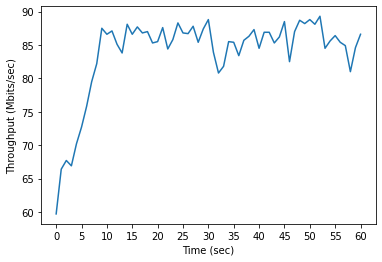

In [2]:
adj_20_20 = [59.7 ,66.4 ,67.7 ,66.9 ,70.2 ,72.7 ,75.8 ,79.5 ,82.2 ,87.5 ,86.6 ,87.1 ,85.1 ,83.8 ,88.1 ,86.6 ,87.7 ,86.8 ,87.0 ,85.3 ,85.5 ,87.6 ,84.4 ,85.8 ,88.3 ,86.8 ,86.7 ,87.8 ,85.4 ,87.4 ,88.8 ,83.9 ,80.8 ,81.8 ,85.5 ,85.4 ,83.4 ,85.7 ,86.3 ,87.3 ,84.5 ,86.9 ,86.9 ,85.3 ,86.2 ,88.5 ,82.5 ,87.0 ,88.7 ,88.2 ,88.8 ,88.1 ,89.3 ,84.5 ,85.6 ,86.4 ,85.4 ,84.9 ,81.0 ,84.6 ,86.6]
plt.plot(x,adj_20_20)
plt.xlabel("Time (sec)")
plt.ylabel("Throughput (Mbits/sec)")
plt.xticks([0 , 5 , 10 , 15 , 20 , 25 , 30 ,35 , 40 , 45 ,50 ,55 ,60])
plt.show()

**Nodes that operate on non-overlapping, yet adjacent, channels, as we see from the plot graph above, still suffer interference from channel leakage when power from transmissions on adjacent channels spills to neighboring channels.**

### 20 Mhz with 40 Mhz adjacent

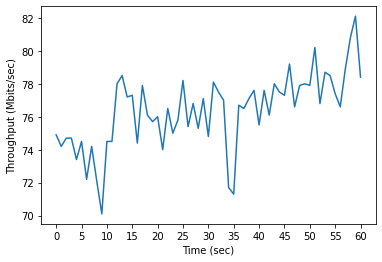

In [3]:
adj_20_40 = [74.9 ,74.2 ,74.7 ,74.7 ,73.4 ,74.5 ,72.2 ,74.2 ,72.1 ,70.1 ,74.5 ,74.5 ,78.0 ,78.5 ,77.2 ,77.3 ,74.4 ,77.9 ,76.1 ,75.7 ,76.0 ,74.0 ,76.5 ,75.0 ,75.8 ,78.2 ,75.4 ,76.8 ,75.3 ,77.1 ,74.8 ,78.1 ,77.5 ,77.0 ,71.7 ,71.3 ,76.7 ,76.5 ,77.1 ,77.6 ,75.5 ,77.6 ,76.1 ,78.0 ,77.5 ,77.3 ,79.2 ,76.6 ,77.9 ,78.0 ,77.9 ,80.2 ,76.8 ,78.7 ,78.5 ,77.4 ,76.6 ,78.9 ,80.8 ,82.1 ,78.4]
plt.plot(x,adj_20_40)
plt.xlabel("Time (sec)")
plt.ylabel("Throughput (Mbits/sec)")
plt.xticks([0 , 5 , 10 , 15 , 20 , 25 , 30 ,35 , 40 , 45 ,50 ,55 ,60])
plt.show()

**A 20MHz transmission has more energy than a 40MHz transmission and, thus, a 20MHz transmission is more easily detected. Therefore, for suffi- ciently strong interferers that activate carrier sensing, 20MHz adj performs better than 40MHz adj. That can be observed easily by comparing the two plot graphs above.**

### Two 20 Mhz sharing the same channel

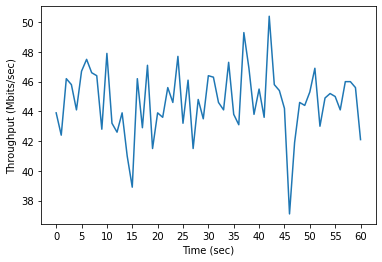

In [4]:
same_20 = [43.9 ,42.4 ,46.2 ,45.8 ,44.1 ,46.7 ,47.5 ,46.6 ,46.4 ,42.8 ,47.9 ,43.2 ,42.6 ,43.9 ,41.0 ,38.9 ,46.2 ,42.9 ,47.1 ,41.5 ,43.9 ,43.6 ,45.6 ,44.6 ,47.7 ,43.2 ,46.1 ,41.5 ,44.8 ,43.5 ,46.4 ,46.3 ,44.6 ,44.1 ,47.3 ,43.8 ,43.1 ,49.3 ,46.9 ,43.8 ,45.5 ,43.6 ,50.4 ,45.8 ,45.4 ,44.2 ,37.1 ,41.9 ,44.6 ,44.4 ,45.3 ,46.9 ,43.0 ,44.9 ,45.2 ,45.0 ,44.1 ,46.0 ,46.0 ,45.6 ,42.1]
plt.plot(x,same_20)
plt.xlabel("Time (sec)")
plt.ylabel("Throughput (Mbits/sec)")
plt.xticks([0 , 5 , 10 , 15 , 20 , 25 , 30 ,35 , 40 , 45 ,50 ,55 ,60])
plt.show()

### 20 Mhz and 40 Mhz sharing the same channel

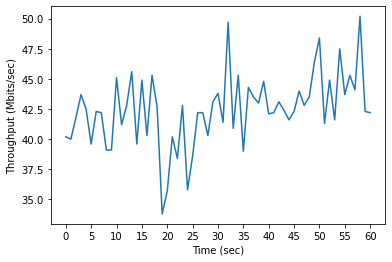

In [5]:
same_20_40 = [40.2 ,40.0 ,41.8 ,43.7 ,42.5 ,39.6 ,42.3 ,42.2 ,39.1 ,39.1 ,45.1 ,41.2 ,42.8 ,45.6 ,39.6 ,44.9 ,40.3 ,45.3 ,42.7 ,33.8 ,35.7 ,40.2 ,38.4 ,42.8 ,35.8 ,38.6 ,42.2 ,42.2 ,40.3 ,43.1 ,43.8 ,41.4 ,49.7 ,40.9 ,45.3 ,39.0 ,44.3 ,43.5 ,43.0 ,44.8 ,42.1 ,42.2 ,43.1 ,42.4 ,41.6 ,42.3 ,44.0 ,42.8 ,43.5 ,46.4 ,48.4 ,41.3 ,44.9 ,41.6 ,47.5 ,43.7 ,45.3 ,44.1 ,50.2 ,42.3 , 42.2]
plt.plot(x,same_20_40)
plt.xlabel("Time (sec)")
plt.ylabel("Throughput (Mbits/sec)")
plt.xticks([0 , 5 , 10 , 15 , 20 , 25 , 30 ,35 , 40 , 45 ,50 ,55 ,60])
plt.show()

## 40 Mhz Under Test


### 40 Mhz link

**Best MCS: MCS21 , index: 145 (SGI 3)**

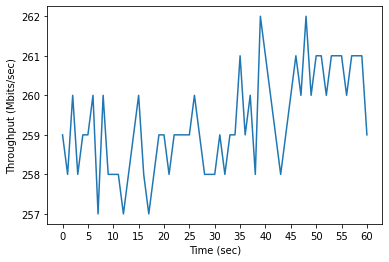

In [6]:
link_40 = [259 ,258 ,260 ,258 ,259 ,259 ,260 ,257 ,260 ,258 ,258 ,258 ,257 ,258 ,259 ,260 ,258 ,257 ,258 ,259 ,259 ,258 ,259 ,259 ,259 ,259 ,260 ,259 ,258 ,258 ,258 ,259 ,258 ,259 ,259 ,261 ,259 ,260 ,258 ,262 ,261 ,260 ,259 ,258 ,259 ,260 ,261 ,260 ,262 ,260 ,261 ,261 ,260 ,261 ,261 ,261 ,260 ,261 ,261 ,261 ,259]
plt.plot(x,link_40)
plt.xlabel("Time (sec)")
plt.ylabel("Throughput (Mbits/sec)")
plt.xticks([0 , 5 , 10 , 15 , 20 , 25 , 30 ,35 , 40 , 45 ,50 ,55 ,60])
plt.show()

### 40 Mhz with 40 Mhz adjacent

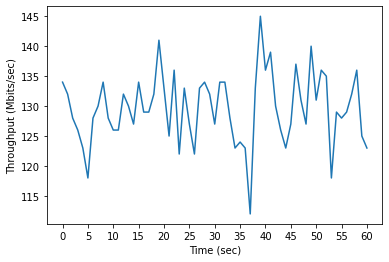

In [7]:
adj_40_40 = [134 ,132 ,128 ,126 ,123 ,118 ,128 ,130 ,134 ,128 ,126 ,126 ,132 ,130 ,127 ,134 ,129 ,129 ,132 ,141 ,133 ,125 ,136 ,122 ,133 ,127 ,122 ,133 ,134 ,132 ,127 ,134 ,134 ,128 ,123 ,124 ,123 ,112 ,133 ,145 ,136 ,139 ,130 ,126 ,123 ,127 ,137 ,131 ,127 ,140 ,131 ,136 ,135 ,118 ,129 ,128 ,129 ,132 ,136 ,125 , 123]
plt.plot(x,adj_40_40)
plt.xlabel("Time (sec)")
plt.ylabel("Throughput (Mbits/sec)")
plt.xticks([0 , 5 , 10 , 15 , 20 , 25 , 30 ,35 , 40 , 45 ,50 ,55 ,60])
plt.show()

### 40 Mhz with 20 Mhz adjacent

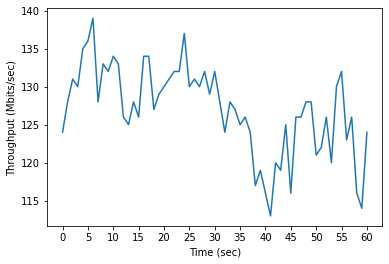

In [8]:
adj_40_20 = [124 ,128 ,131 ,130 ,135 ,136 ,139 ,128 ,133 ,132 ,134 ,133 ,126 ,125 ,128 ,126 ,134 ,134 ,127 ,129 ,130 ,131 ,132 ,132 ,137 ,130 ,131 ,130 ,132 ,129 ,132 ,128 ,124 ,128 ,127 ,125 ,126 ,124 ,117 ,119 ,116 ,113 ,120 ,119 ,125 ,116 ,126 ,126 ,128 ,128 ,121 ,122 ,126 ,120 ,130 ,132 ,123 ,126 ,116 ,114 ,124]
plt.plot(x,adj_40_20)
plt.xlabel("Time (sec)")
plt.ylabel("Throughput (Mbits/sec)")
plt.xticks([0 , 5 , 10 , 15 , 20 , 25 , 30 ,35 , 40 , 45 ,50 ,55 ,60])
plt.show()

**Two 40 Mhz sharing the same channel**

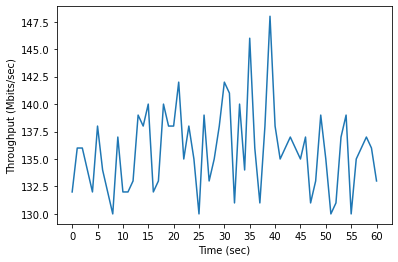

In [9]:
same_40 = [132 ,136 ,136 ,134 ,132 ,138 ,134 ,132 ,130 ,137 ,132 ,132 ,133 ,139 ,138 ,140 ,132 ,133 ,140 ,138 ,138 ,142 ,135 ,138 ,135 ,130 ,139 ,133 ,135 ,138 ,142 ,141 ,131 ,140 ,134 ,146 ,136 ,131 ,138 ,148 ,138 ,135 ,136 ,137 ,136 ,135 ,137 ,131 ,133 ,139 ,135 ,130 ,131 ,137 ,139 ,130 ,135 ,136 ,137 ,136 ,133]
plt.plot(x,same_40)
plt.xlabel("Time (sec)")
plt.ylabel("Throughput (Mbits/sec)")
plt.xticks([0 , 5 , 10 , 15 , 20 , 25 , 30 ,35 , 40 , 45 ,50 ,55 ,60])
plt.show()

### 40 Mhz and 20 Mhz sharing the same channel

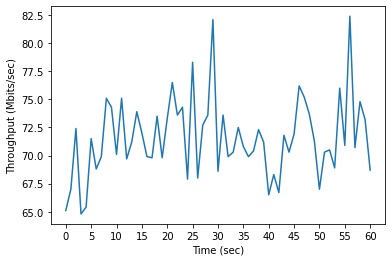

In [10]:
share_40_20 = [65.1 ,67.0 ,72.4 ,64.8 ,65.4 ,71.5 ,68.8 ,69.9 ,75.1 ,74.3 ,70.1 ,75.1 ,69.7 ,71.2 ,73.9 ,72.0 ,69.9 ,69.8 ,73.5 ,69.8 ,73.3 ,76.5 ,73.6 ,74.3 ,67.9 ,78.3 ,68.0 ,72.7 ,73.6 ,82.1 ,68.6 ,73.6 ,69.9 ,70.3 ,72.5 ,70.8 ,69.9 ,70.4 ,72.3 ,71.2 ,66.5 ,68.3 ,66.7 ,71.8 ,70.3 ,71.9 ,76.2 ,75.2 ,73.7 ,71.3 ,67.0 ,70.3 ,70.5 ,68.9 ,76.0 ,70.9 ,82.4 ,70.7 ,74.8 ,73.2 ,68.7]
plt.plot(x,share_40_20)
plt.xlabel("Time (sec)")
plt.ylabel("Throughput (Mbits/sec)")
plt.xticks([0 , 5 , 10 , 15 , 20 , 25 , 30 ,35 , 40 , 45 ,50 ,55 ,60])
plt.show()

### General Observations

- **If the interferer operates on an adjacent 20MHz channel (20MHz adj), then channel bonding degrades performance.**

- **If the interferer operates on an adjacent 40MHz channel (40MHz adj), channel bonding improves performance.**

- **If the interfering channel is separated by 20MHz, channel bonding always improves performance.**

- **Our findings on channel sharing show that, regardless of the bandwidth of under test link, it is more advantageous for under test link to compete for the channel with an interferer who transmits at 40MHz: 40MHz interferers attain higher transmission rates and alleviate fairness issues in multi-rate scenarios, leading to better performance**


